# Natures Eye

## Introduction

While technology has improved our lives in many ways it has alienated us from nature. This model will will turn technology into a tool that connects us to the world.

### Import Libraries and Define Functions

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import seaborn as sns
import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models, layers, regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread 
from PIL import Image

# Neural network libraries

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, optimizers, losses, metrics
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report, recall_score, ConfusionMatrixDisplay
from sklearn.dummy import DummyClassifier
np.random.seed(42)

import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader

%matplotlib inline

import tensorflow as tf
import cv2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random

In [30]:
from keras.layers.convolutional import Conv2D

In [33]:
from keras.layers import Activation, Dense

In [31]:
def show_metrics(history):
    results = history.history
    plt.figure()
    plt.plot(results['val_accuracy'], label = 'Validation Accuracy')
    plt.plot(results['accuracy'], label = 'Train Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show();
    
    plt.figure()
    plt.plot(results['val_recall'], label = 'Validation Recall')
    plt.plot(results['recall'], label = 'Train Recall')
    plt.title('Recall Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.show();
    
    plt.figure()
    plt.plot(results['val_loss'], label = 'Validation Loss')
    plt.plot(results['loss'], label = 'Train Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show();

In [5]:
# Create function to display confusion matrices for models
def conf_mat(model):
    y_pred = model.predict(test_set)
    y_pred = (y_pred>0.5).astype(np.int)
    display(ConfusionMatrixDisplay(confusion_matrix(test_set.classes, y_pred), display_labels=['Normal', 'Pneumonia']).plot())

In [ ]:
# function for the showing the image.
def show_image(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
class Model(ImageClassificationBase):
    def __init__(self, input_size, output_size):
        super().__init__()
        # hidden layer
        self.in_layer = nn.Linear(input_size, 8384)
        self.hidden1 = nn.Linear(8384, 4192)
        self.hidden2 = nn.Linear(4192, 2096)
        self.hidden3 = nn.Linear(2096, 1048)
        self.out_layer = nn.Linear(1048, output_size)
        
    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        out = self.in_layer(out)
        out = self.hidden1(F.relu(out))
        out = self.hidden2(F.relu(out))
        out = self.hidden3(F.relu(out))
        out = self.out_layer(F.relu(out))
        return out

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()
    
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

## Data Understanding

## Data Cleaning

### Data Loading

In [6]:
#train_data_dir = 'ZhangLabData/CellData/chest_xray/train'
train_path = 'archive/animals'

#Get all the data in the directory data/validation (624 images), and reshape them
#test_generator = ImageDataGenerator().flow_from_directory(
#       test_data_dir, 
#       target_size=(64, 64), batch_size=624, color_mode='grayscale', class_mode='binary')

#Get all the data in the directory data/train (5232 images), and reshape them
train_generator = ImageDataGenerator().flow_from_directory(
       train_path, 
       target_size=(64, 64), color_mode='rgb', class_mode='categorical')

#Create the datasets
train_images, train_labels = next(train_generator)
#test_images, test_labels = next(test_generator)

Found 5400 images belonging to 90 classes.


In [7]:
#train_labels[:10]
train_labels[1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.], dtype=float32)

In [8]:
train_generator.class_indices

{'antelope': 0,
 'badger': 1,
 'bat': 2,
 'bear': 3,
 'bee': 4,
 'beetle': 5,
 'bison': 6,
 'boar': 7,
 'butterfly': 8,
 'cat': 9,
 'caterpillar': 10,
 'chimpanzee': 11,
 'cockroach': 12,
 'cow': 13,
 'coyote': 14,
 'crab': 15,
 'crow': 16,
 'deer': 17,
 'dog': 18,
 'dolphin': 19,
 'donkey': 20,
 'dragonfly': 21,
 'duck': 22,
 'eagle': 23,
 'elephant': 24,
 'flamingo': 25,
 'fly': 26,
 'fox': 27,
 'goat': 28,
 'goldfish': 29,
 'goose': 30,
 'gorilla': 31,
 'grasshopper': 32,
 'hamster': 33,
 'hare': 34,
 'hedgehog': 35,
 'hippopotamus': 36,
 'hornbill': 37,
 'horse': 38,
 'hummingbird': 39,
 'hyena': 40,
 'jellyfish': 41,
 'kangaroo': 42,
 'koala': 43,
 'ladybugs': 44,
 'leopard': 45,
 'lion': 46,
 'lizard': 47,
 'lobster': 48,
 'mosquito': 49,
 'moth': 50,
 'mouse': 51,
 'octopus': 52,
 'okapi': 53,
 'orangutan': 54,
 'otter': 55,
 'owl': 56,
 'ox': 57,
 'oyster': 58,
 'panda': 59,
 'parrot': 60,
 'pelecaniformes': 61,
 'penguin': 62,
 'pig': 63,
 'pigeon': 64,
 'porcupine': 65,
 'pos

## dummy classifer/regressor for baseline

In [10]:
#dummy classifer/regressor for baseline
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy='uniform')
dummy.fit(X_train, y_train)

DummyClassifier(strategy='uniform')

In [11]:
dummy.score(X_val, y_val)

0.0

In [12]:
dummy.predict(X_val)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 1.

## Torch Model

In [22]:
#conda install pytorch torchvision cpuonly -c pytorch

In [23]:
#conda update -n base -c defaults conda

In [6]:
data_dir = 'archive/animals'
classes = os.listdir(data_dir)

Transform the data

In [7]:
train_transform=transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(100),             # resize shortest side to 100 pixels
        transforms.CenterCrop(100),         # crop longest side to 100 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [8]:
dataset = ImageFolder(data_dir, transform=train_transform)
print('Size of training dataset :', len(dataset))

Size of training dataset : 5400


In [9]:
# view one image shape of the dataset.
img, label = dataset[100]
print(img.shape)

torch.Size([3, 100, 100])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  bear (3)


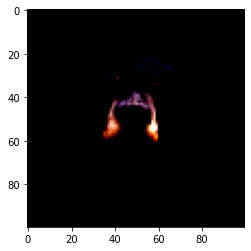

In [11]:
show_image(*dataset[200])

In [12]:
torch.manual_seed(20)
val_size = len(dataset)//10
test_size = len(dataset)//5
train_size = len(dataset) - val_size -test_size

In [13]:
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds),len(test_ds)  

(3780, 540, 1080)

In [14]:
batch_size = 64
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size*2, num_workers=4, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


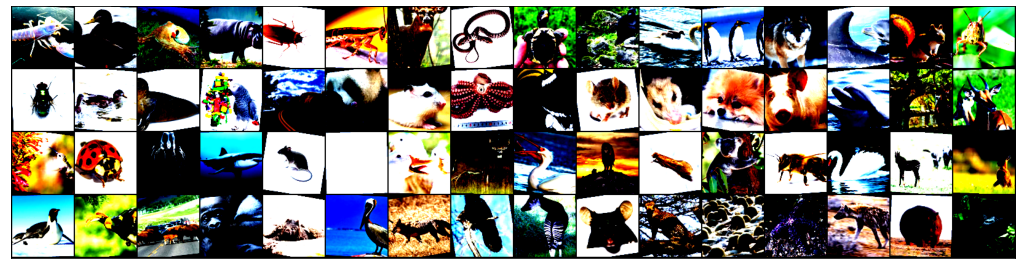

In [11]:
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

In [14]:
torch.cuda.is_available()

False

In [16]:
device = get_default_device()
device

device(type='cpu')

In [17]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [18]:
input_size = 3*100*100
output_size = 91 # Number of classes

## Linear Model

In [20]:
model = to_device(Model(input_size, output_size), device)

In [21]:
model

Model(
  (in_layer): Linear(in_features=30000, out_features=8384, bias=True)
  (hidden1): Linear(in_features=8384, out_features=4192, bias=True)
  (hidden2): Linear(in_features=4192, out_features=2096, bias=True)
  (hidden3): Linear(in_features=2096, out_features=1048, bias=True)
  (out_layer): Linear(in_features=1048, out_features=91, bias=True)
)

In [22]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 4.5135979652404785, 'val_acc': 0.01406249962747097}]

In [23]:
history += fit(7, 0.01, model, train_loader, val_loader)


Epoch [0], train_loss: 4.5077, val_loss: 4.5078, val_acc: 0.0196



Epoch [1], train_loss: 4.4972, val_loss: 4.5012, val_acc: 0.0243



Epoch [2], train_loss: 4.4844, val_loss: 4.4926, val_acc: 0.0330



Epoch [3], train_loss: 4.4666, val_loss: 4.4828, val_acc: 0.0268



Epoch [4], train_loss: 4.4392, val_loss: 4.4644, val_acc: 0.0330



Epoch [5], train_loss: 4.4050, val_loss: 4.4377, val_acc: 0.0440



Epoch [6], train_loss: 4.3633, val_loss: 4.4019, val_acc: 0.0408


In [24]:
history += fit(4, 0.001, model, train_loader, val_loader)


Epoch [0], train_loss: 4.3279, val_loss: 4.3978, val_acc: 0.0424



Epoch [1], train_loss: 4.3155, val_loss: 4.3939, val_acc: 0.0408



Epoch [2], train_loss: 4.3092, val_loss: 4.3899, val_acc: 0.0440



Epoch [3], train_loss: 4.3022, val_loss: 4.3846, val_acc: 0.0424


In [25]:
history += fit(3, 0.0001, model, train_loader, val_loader)


Epoch [0], train_loss: 4.2989, val_loss: 4.3825, val_acc: 0.0424



Epoch [1], train_loss: 4.2991, val_loss: 4.3845, val_acc: 0.0424



Epoch [2], train_loss: 4.2871, val_loss: 4.3822, val_acc: 0.0408


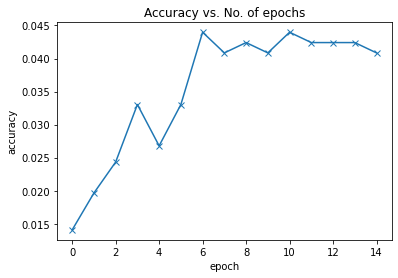

In [27]:
plot_accuracies(history)

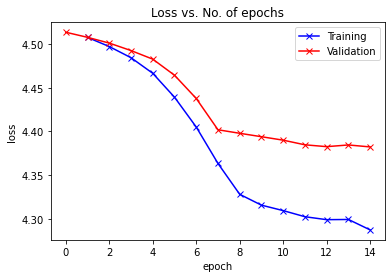

In [28]:
plot_losses(history)

In [29]:
evaluate(model, test_loader)

{'val_loss': 4.334440231323242, 'val_acc': 0.0386904738843441}

## Dense Net

In [31]:
#pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [16]:
Name = os.listdir(data_dir)
print(Name)
print(len(Name))

['antelope', 'badger', 'bat', 'bear', 'bee', 'beetle', 'bison', 'boar', 'butterfly', 'cat', 'caterpillar', 'chimpanzee', 'cockroach', 'cow', 'coyote', 'crab', 'crow', 'deer', 'dog', 'dolphin', 'donkey', 'dragonfly', 'duck', 'eagle', 'elephant', 'flamingo', 'fly', 'fox', 'goat', 'goldfish', 'goose', 'gorilla', 'grasshopper', 'hamster', 'hare', 'hedgehog', 'hippopotamus', 'hornbill', 'horse', 'hummingbird', 'hyena', 'jellyfish', 'kangaroo', 'koala', 'ladybugs', 'leopard', 'lion', 'lizard', 'lobster', 'mosquito', 'moth', 'mouse', 'octopus', 'okapi', 'orangutan', 'otter', 'owl', 'ox', 'oyster', 'panda', 'parrot', 'pelecaniformes', 'penguin', 'pig', 'pigeon', 'porcupine', 'possum', 'raccoon', 'rat', 'reindeer', 'rhinoceros', 'sandpiper', 'seahorse', 'seal', 'shark', 'sheep', 'snake', 'sparrow', 'squid', 'squirrel', 'starfish', 'swan', 'tiger', 'turkey', 'turtle', 'whale', 'wolf', 'wombat', 'woodpecker', 'zebra']
90


In [34]:
N=list(range(len(Name)))
normal_mapping=dict(zip(Name,N)) 
reverse_mapping=dict(zip(N,Name)) 

In [35]:
path0='archive/animals'
image=cv2.imread(path0)
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
plt.show()
sp=image.shape

image2=image[(sp[0]//3):(sp[0]*2//3),(sp[1]//3):(sp[1]*2//3),:]
plt.imshow(cv2.cvtColor(image2,cv2.COLOR_BGR2RGB))
plt.show()

image3=cv2.resize(image2,dsize=(32,32),interpolation=cv2.INTER_CUBIC)
plt.imshow(cv2.cvtColor(image3,cv2.COLOR_BGR2RGB))
plt.show()

error: OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [36]:
dataX=[]
dataY0=[]
count=0
for name in tqdm(os.listdir(data_dir)):
    path=os.path.join(data_dir,name)
    for im in os.listdir(path):
        image=cv2.imread(os.path.join(path,im))
        if type(image)==np.ndarray:
            sp=image.shape
            image2=image[(sp[0]//3):(sp[0]*2//3),(sp[1]//3):(sp[1]*2//3),:]
            image3=cv2.resize(image2,dsize=(32,32),interpolation=cv2.INTER_CUBIC)
            dataX+=[image3]
            dataY0+=[count]
    count=count+1

100%|██████████| 90/90 [00:51<00:00,  1.76it/s]


In [37]:
m=len(dataX)
M=list(range(m))
random.seed(2021)
random.shuffle(M)

dataX=np.array(dataX)
dataY0=np.array(dataY0)

trainX=dataX[M[0:(m//4)*3]]
trainY0=dataY0[M[0:(m//4)*3]]

testX=dataX[M[(m//4)*3:]]
testY0=dataY0[M[(m//4)*3:]]

In [38]:
labels1=to_categorical(trainY0)
trainY=np.array(labels1)

In [39]:
trainX=np.array(trainX)
testX=np.array(testX)

In [40]:
trainx,testx,trainy,testy=train_test_split(trainX,trainY,test_size=0.2,random_state=44)

In [41]:
datagen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=20,zoom_range=0.2,
                        width_shift_range=0.2,height_shift_range=0.2,shear_range=0.1,fill_mode="nearest")

In [42]:
pretrained_model3 = tf.keras.applications.DenseNet201(input_shape=(32,32,3),include_top=False,weights='imagenet',pooling='avg')
pretrained_model3.trainable = False

74842112/74836368 [==============================] - 22s 0us/step


In [43]:
inputs3 = pretrained_model3.input
x3 = tf.keras.layers.Dense(128, activation='relu')(pretrained_model3.output)
outputs3 = tf.keras.layers.Dense(len(Name), activation='softmax')(x3)
model = tf.keras.Model(inputs=inputs3, outputs=outputs3)

In [44]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [46]:
his=model.fit(datagen.flow(trainx,trainy,batch_size=32),validation_data=(testx,testy),epochs=10)

Epoch 1/10
102/102 [==============================] - 11s 104ms/step - loss: 4.3289 - accuracy: 0.0577 - val_loss: 4.4191 - val_accuracy: 0.0506
Epoch 2/10
102/102 [==============================] - 12s 121ms/step - loss: 4.1561 - accuracy: 0.0731 - val_loss: 4.3483 - val_accuracy: 0.0654
Epoch 3/10
102/102 [==============================] - 14s 133ms/step - loss: 4.0256 - accuracy: 0.0935 - val_loss: 4.2752 - val_accuracy: 0.0815
Epoch 4/10
102/102 [==============================] - 13s 132ms/step - loss: 3.9252 - accuracy: 0.1080 - val_loss: 4.2008 - val_accuracy: 0.1000
Epoch 5/10
102/102 [==============================] - 14s 140ms/step - loss: 3.7836 - accuracy: 0.1278 - val_loss: 4.5207 - val_accuracy: 0.0741
Epoch 6/10
102/102 [==============================] - 14s 134ms/step - loss: 3.7151 - accuracy: 0.1284 - val_loss: 4.2632 - val_accuracy: 0.1025
Epoch 7/10
102/102 [==============================] - 13s 131ms/step - loss: 3.6567 - accuracy: 0.1478 - val_loss: 4.1703 - val_ac

In [47]:
y_pred=model.predict(testx)
pred=np.argmax(y_pred,axis=1)
ground = np.argmax(testy,axis=1)
print(classification_report(ground,pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00        12
           3       0.14      0.10      0.12        10
           4       0.00      0.00      0.00         7
           5       0.00      0.00      0.00        11
           6       0.00      0.00      0.00         7
           7       0.00      0.00      0.00         6
           8       0.19      0.64      0.29        11
           9       0.00      0.00      0.00         8
          10       0.20      0.12      0.15         8
          11       0.00      0.00      0.00         9
          12       0.10      0.25      0.14        12
          13       0.00      0.00      0.00         8
          14       0.00      0.00      0.00         7
          15       0.00      0.00      0.00         5
          16       0.00      0.00      0.00         9
          17       0.00    

C:\Users\danie\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


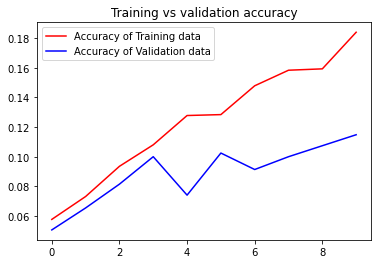

<Figure size 432x288 with 0 Axes>

In [48]:
get_acc = his.history['accuracy']
value_acc = his.history['val_accuracy']
get_loss = his.history['loss']
validation_loss = his.history['val_loss']

epochs = range(len(get_acc))
plt.plot(epochs, get_acc, 'r', label='Accuracy of Training data')
plt.plot(epochs, value_acc, 'b', label='Accuracy of Validation data')
plt.title('Training vs validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

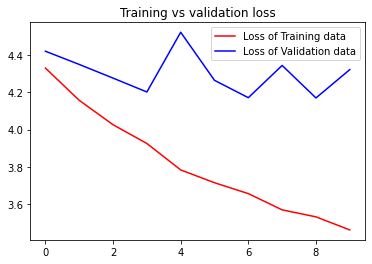

<Figure size 432x288 with 0 Axes>

In [49]:
epochs = range(len(get_loss))
plt.plot(epochs, get_loss, 'r', label='Loss of Training data')
plt.plot(epochs, validation_loss, 'b', label='Loss of Validation data')
plt.title('Training vs validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [50]:
pred2=model.predict(testX)
print(pred2.shape)

PRED=[]
for item in pred2:
    value2=np.argmax(item)      
    PRED+=[value2]
print(pd.Series(PRED).value_counts())

(1350, 90)
65    330
8      61
12     55
83     51
45     41
     ... 
68      1
36      1
18      1
20      1
50      1
Length: 76, dtype: int64


In [51]:
ANS=testY0
accuracy=accuracy_score(ANS,PRED)
print(accuracy)

0.09703703703703703


Lets view some predictions

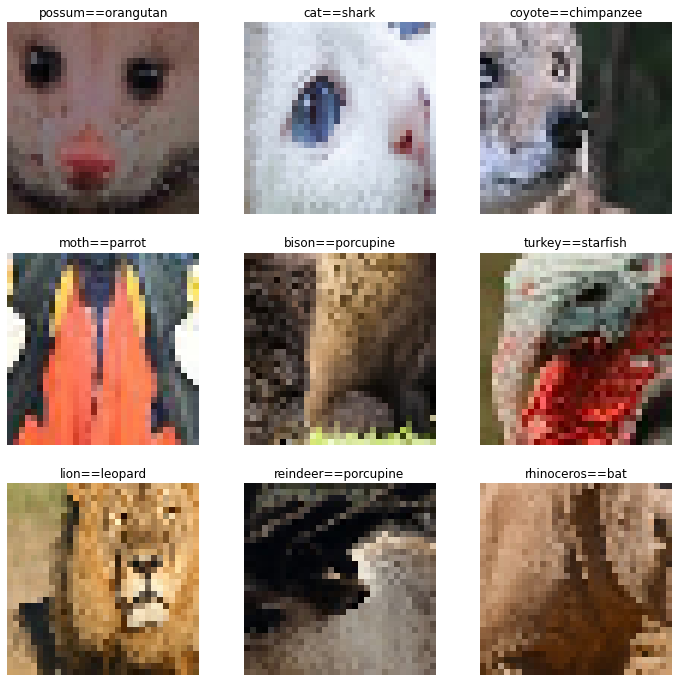

In [52]:
fig, axs = plt.subplots(3,3,figsize=(12,12))
for i in range(9):
    r=i//3
    c=i%3
    img1 = testX[i]
    ax=axs[r][c].axis("off")
    actual=reverse_mapping[ANS[i]]
    predict=reverse_mapping[PRED[i]]    
    ax=axs[r][c].set_title(actual+'=='+predict)
    ax=axs[r][c].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.show()

## CNN

## Evaluation

## Summary

My current best model has an accuracy under 20% it needs improvement.